In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
     for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt
/kaggle/input/imdb-spoiler-dataset/IMDB_movie_details.json
/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

In [4]:
df_reviews = pd.read_json('../input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)
df_details = pd.read_json('../input/imdb-spoiler-dataset/IMDB_movie_details.json',lines =True)

In [5]:
def get_part_data(df, num_reviews):
    
    num_pos_reviews = df[df["is_spoiler"]== True].shape[0]  # Number of spoilers in the dataset
    num_neg_reviews = df[df["is_spoiler"]== False].shape[0] # Number of Non-spoilers in the dataset
    
    fraction_pos = num_reviews/num_pos_reviews  # fraction of spoiler reviews to be returned
    fraction_neg = num_reviews/num_neg_reviews  # fraction of non-spoiler reviews to be returned 

    df_pos = df[df['is_spoiler'] == True].sample(frac = fraction_pos, random_state = 2)
    df_neg = df[df['is_spoiler'] == False].sample(frac = fraction_neg, random_state = 2)

    df_re = pd.concat([df_pos, df_neg])  # join the True and False dataset
    df_re = df_re.reset_index(drop=True)  # mix the index values
    df_re.loc[(df_re['is_spoiler'] == True) ,'is_spoiler'] =1
    df_re.loc[(df_re['is_spoiler'] == False) ,'is_spoiler'] =0
    return df_re[["movie_id","review_text","review_summary","is_spoiler"]]

In [6]:
old_data = get_part_data(df_reviews, 110000)
#old_data["is_spoiler"] = d["is_spoiler"].astype('int')
#ndata = old_data[["review_text","review_summary","is_spoiler"]]

In [7]:
le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(old_data['review_text'].values,old_data['is_spoiler'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

In [8]:
print(training_reviews.shape)
print(testing_reviews.shape)

(176000,)
(44000,)


### Preprocess the text
Using tokenizer to produce token for a given word and taking maximum length of 200 character of a review and after we simply truncate the input review and then padded the input to max len of 200

In [12]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 400,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 400,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 214738


### Using Glove embedding with LSTM layer

layer1: Embedding Layer using glove weights

layer2: Using a Bidirectional LSTM

layer3: A dropout Layer

layer4: A Dense layer of 256 neurons with 'relu' activation

layer5: A Dense Layer of 128 neurons with 'relu' activation

layer6: Again a dropout layer.

layer7: Sigmoid activation layer to classify it positive and negative.

In [17]:
embedded_words = {}
with open('../input/glove-embeddings/glove.6B.300d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [18]:
embedding_matrix = np.zeros((len(word_index) + 1,300))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=300,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          64421700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [21]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
history = model.fit(train_pad_sequence,training_labels,epochs = 10 ,validation_data=(test_pad_sequence,testing_labels))

2022-03-08 15:29:36.020169: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-08 15:29:40.076002: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5500/5500 [==============================] - 198s 35ms/step - loss: 0.6592 - accuracy: 0.6061 - val_loss: 0.6043 - val_accuracy: 0.6784
Epoch 2/10
5500/5500 [==============================] - 192s 35ms/step - loss: 0.5915 - accuracy: 0.6865 - val_loss: 0.5761 - val_accuracy: 0.6945
Epoch 3/10
5500/5500 [==============================] - 196s 36ms/step - loss: 0.5725 - accuracy: 0.6988 - val_loss: 0.5690 - val_accuracy: 0.6991
Epoch 4/10
5500/5500 [==============================] - 192s 35ms/step - loss: 0.5616 - accuracy: 0.7074 - val_loss: 0.5664 - val_accuracy: 0.7014
Epoch 5/10
5500/5500 [==============================] - 196s 36ms/step - loss: 0.5518 - accuracy: 0.7145 - val_loss: 0.5663 - val_accuracy: 0.7029
Epoch 6/10
5500/5500 [==============================] - 192s 35ms/step - loss: 0.5409 - accuracy: 0.7222 - val_loss: 0.5644 - val_accuracy: 0.7017
Epoch 7/10
5500/5500 [==============================] - 196s 36ms/step - loss: 0.5305 - accuracy: 0.7308 - val_loss: 0.5666 - val

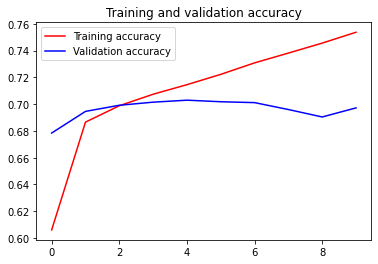

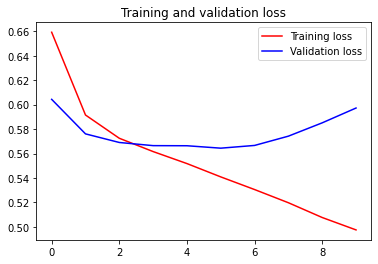

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [23]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.7536306977272034
Validation Accuracy: 0.7029091119766235
